# Reference code: JAK2 activity optimization with ReLeaSE algorithm

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import numpy as np
import pandas as pd
import selfies as sf
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [5]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData

## Setting up the generator

### Loading data for the generator

In [6]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'gsk3_jnk3_qed_sa')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_1_pretraining_ReBADD', 'gsk3_jnk3_qed_sa')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [7]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 781797
Number of vocabulary: 53687
Maximum of seqlen: 40


## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

Initialize stack-augmented generative RNN:

In [8]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-3,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [9]:
my_generator = StackAugmentedVAE(**kwargs_generator)

If you want train the model from scratch, uncomment the lines below:

In [10]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.txt')

In [11]:
losses = my_generator.fit(gen_data, n_iterations=20000,
                          batch_size=50,
                          print_every=1000,
                          ckpt_every=1000,
                          model_path=model_path,
                          losses_path=losses_path)

Training in progress...:   5%|████████                                                                                                                                                        | 1000/20000 [28:45<8:38:22,  1.64s/it]

[01000 (5.0%) 28m 44s], Loss_vae:4.474, Loss_rec:4.240, Loss_kld:13.183, Beta:0.050
selfies: [C][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][Branch1][=N][C][C][Ring1][Branch1][Branch1][C][O][C][C][C][Ring1][Ring1][Branch1][Branch1][C][C][Ring1][#Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1]
smiles: CC1=CC=C(C2=C1)NCC2(O)C3CC3(CC)CCC4=CC=CC=C4


Training in progress...:  10%|████████████████                                                                                                                                                | 2000/20000 [57:28<8:52:59,  1.78s/it]

[02000 (10.0%) 57m 28s], Loss_vae:3.869, Loss_rec:3.573, Loss_kld:4.169, Beta:0.100
selfies: [C][O][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][N][C][=N][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][C][=C][C][=C][Branch1][Branch2][C][Branch1][C][O][=C][Ring1][#Branch1][C][=C][Ring1][N][C][C]
smiles: COC1=CC=CC(=C1)NC2=NC=C3C(=C2)C4=CC=C(C(O)=C4)C=C3CC


Training in progress...:  15%|███████████████████████▋                                                                                                                                      | 3000/20000 [1:26:10<7:53:45,  1.67s/it]

[03000 (15.0%) 86m 10s], Loss_vae:3.728, Loss_rec:3.572, Loss_kld:1.313, Beta:0.150
selfies: [C][C][=C][C][Branch1][C][C][C][O][C][=N][C][N][=C][N][C][=C][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][C][N][Branch1][Branch1][C][C][Ring1][=Branch1][C][=C][C][=C][C][=N][Ring1][=Branch1]
smiles: CC=CC(C)COC=NCN=CNC=CC=CC1=CC=CC=C1N2CCN(CC2)C3=CC=CC=N3


Training in progress...:  20%|███████████████████████████████▌                                                                                                                              | 3999/20000 [1:54:55<8:08:00,  1.83s/it]

[04000 (20.0%) 114m 57s], Loss_vae:3.594, Loss_rec:3.546, Loss_kld:0.283, Beta:0.200
selfies: [O][=C][O][C][=C][C][=Branch1][Branch2][=C][C][=C][Ring1][#Branch2][Ring1][=Branch1][C][C][=Branch1][C][=O][N][C][C][C][Branch1][Branch1][C][C][Ring1][=Branch1][N][C][C][C][Branch1][Ring1][C][C][C][C][Branch1][Ring2][C][Ring1][#Branch1][C][Ring1][#Branch2][C][C][=Branch1][C][=O][C][=C][N][Branch1][C][C][C][=N][Ring1][=Branch1]
smiles: O=COC1=CC(=CC=C1)CC(=O)N2CCC(CC2)N3CC4C(CC)CC(C4)C3CC(=O)C5=CN(C)C=N5


Training in progress...:  25%|███████████████████████████████████████▌                                                                                                                      | 5000/20000 [2:23:41<6:53:22,  1.65s/it]

[05000 (25.0%) 143m 41s], Loss_vae:3.489, Loss_rec:3.466, Loss_kld:0.104, Beta:0.250
selfies: [C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C][C][C][C][C][C][N][N][#C][C][=C][O][C][=C][C][=C][C][C][=C][N][C][=C][C][=C][C][=C][Ring1][=Branch2][Ring1][=Branch1]
smiles: COC1=CC=CC=C1NC(=O)CCCCCCNN=CC=COC=CC=CCC2=CNC3=CC=CC=C23


Training in progress...:  30%|███████████████████████████████████████████████▍                                                                                                              | 6000/20000 [2:52:26<7:09:00,  1.84s/it]

[06000 (30.0%) 172m 26s], Loss_vae:3.409, Loss_rec:3.391, Loss_kld:0.066, Beta:0.300
selfies: [N][#C][C][Branch1][=C][C][=N][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring1][=Branch2][=C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring1][=Branch2]
smiles: N#CC(C1=NC2=CC=CC=C2N1)=C3NC4=CC=CC=C4N3


Training in progress...:  35%|███████████████████████████████████████████████████████▎                                                                                                      | 7000/20000 [3:21:09<6:27:41,  1.79s/it]

[07000 (35.0%) 201m 9s], Loss_vae:3.351, Loss_rec:3.334, Loss_kld:0.052, Beta:0.350
selfies: [O][=C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=C][C][=C][C][Branch1][O][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][Branch1][O][C][=Branch1][C][=O][C][Ring1][Branch2][=C][Ring1][N]
smiles: O=C(C1=CC=CC=C1)NC=CC=CC(C2=CC3=C4C=CC=C3)C(=O)C4=C2


Training in progress...:  40%|███████████████████████████████████████████████████████████████▏                                                                                              | 7999/20000 [3:49:45<5:17:46,  1.59s/it]

[08000 (40.0%) 229m 47s], Loss_vae:3.315, Loss_rec:3.297, Loss_kld:0.047, Beta:0.400
selfies: [C][C][C][Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Branch1][O][C][=C][C][=C][C][=C][Ring1][N][Ring1][=Branch1][C][=C][C][=C][Branch1][Ring1][C][#N][C][Branch1][C][Cl][=C][Ring1][=Branch2][Cl]
smiles: CCC(C)C1=C2C=CC=C1N(C3=CC=CC=C23)C4=CC=C(C#N)C(Cl)=C4Cl


Training in progress...:  45%|███████████████████████████████████████████████████████████████████████                                                                                       | 9000/20000 [4:18:33<5:31:45,  1.81s/it]

[09000 (45.0%) 258m 33s], Loss_vae:3.279, Loss_rec:3.261, Loss_kld:0.042, Beta:0.450
selfies: [N][C][=N][C][Branch1][=Branch2][C][=N][C][Ring1][#Branch1][=C][Ring1][O][=C][C][=C][Ring1][=C][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1]
smiles: N12C=NC(C=NC1=C2)=CC=CC3=CC=C(Cl)C=C3


Training in progress...:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 10000/20000 [4:47:19<5:11:56,  1.87s/it]

[10000 (50.0%) 287m 19s], Loss_vae:3.265, Loss_rec:3.247, Loss_kld:0.038, Beta:0.500
selfies: [N][C][=N][C][=Branch1][Branch1][=C][S][Ring1][Branch1][C][C][=C][C][=C][C][=C][C][=C][C][Ring1][=Branch1][=C][Ring1][#Branch2]
smiles: NC1=NC(=CS1)CC2=CC=C3C=CC=CC3=C2


Training in progress...:  55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11000/20000 [5:16:01<4:41:28,  1.88s/it]

[11000 (55.0%) 316m 0s], Loss_vae:3.241, Loss_rec:3.223, Loss_kld:0.035, Beta:0.550
selfies: [C][C][Branch1][Branch1][C][C][Ring1][Ring1][O][C][C][O][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1]
smiles: CC1(CC1)OCCOC2=CC=C(Cl)C=C2


Training in progress...:  60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12000/20000 [5:44:48<3:59:20,  1.80s/it]

[12000 (60.0%) 344m 48s], Loss_vae:3.212, Loss_rec:3.194, Loss_kld:0.031, Beta:0.600
selfies: [N][C][=N][C][Branch1][C][N][=N][C][=C][Ring1][#Branch1][N][=C][N][Ring1][Branch1][C][C][Branch1][C][O][C][O]
smiles: NC1=NC(N)=NC2=C1N=CN2CC(O)CO


Training in progress...:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13000/20000 [6:13:33<3:30:53,  1.81s/it]

[13000 (65.0%) 373m 33s], Loss_vae:3.200, Loss_rec:3.181, Loss_kld:0.030, Beta:0.650
selfies: [C][N][C][=N][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring1][=Branch2][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][S][Ring1][Branch1]
smiles: CNC1=NC2=CC=CC=C2N1S(=O)(=O)C3=CC=CS3


Training in progress...:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14000/20000 [6:42:19<2:55:40,  1.76s/it]

[14000 (70.0%) 402m 18s], Loss_vae:3.182, Loss_rec:3.162, Loss_kld:0.029, Beta:0.700
selfies: [C][O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][N][C][=N][C][=C][C][=Branch1][Ring2][=N][Ring1][=Branch1][Branch1][Branch1][C][Ring1][Branch1][O][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][O][Ring1][=Branch2]
smiles: COC1=CC=C(C=C1)NC2=NC3=CC(=N2)C3OC4=CC5=CC=CC=C5O4


Training in progress...:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15000/20000 [7:11:05<2:26:13,  1.75s/it]

[15000 (75.0%) 431m 5s], Loss_vae:3.170, Loss_rec:3.149, Loss_kld:0.028, Beta:0.750
selfies: [N][#C][C][=C][Branch1][O][N][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][=C][Branch1][=Branch1][N][C][Ring1][=N][=O][N][C][C][N][Branch1][Branch1][C][C][Ring1][=Branch1][C][=C][C][=C][O][C][O][C][Ring1][Branch1][=C][Ring1][=Branch2]
smiles: N#CC=C(NCC1=CC=CC=C1)N=C(NC=O)N2CCN(CC2)C3=CC=C4OCOC4=C3


Training in progress...:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 16000/20000 [7:39:48<2:02:59,  1.84s/it]

[16000 (80.0%) 459m 47s], Loss_vae:3.162, Loss_rec:3.140, Loss_kld:0.028, Beta:0.800
selfies: [C][S][C][=C][C][=C][C][Branch1][=Branch2][N][C][C][O][C][C][Ring1][=Branch1][=N][C][Branch1][=C][N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][N][C][C][N]
smiles: CSC=CC=CC(N1CCOCC1)=NC(NC2=CC=C(F)C=C2F)NCCN


Training in progress...:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 17000/20000 [8:08:30<1:25:34,  1.71s/it]

[17000 (85.0%) 488m 29s], Loss_vae:3.145, Loss_rec:3.122, Loss_kld:0.028, Beta:0.850
selfies: [C][C][O][C][=Branch1][C][=O][C][=C][N][=C][C][Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][Ring1][#Branch2][C][N][Branch1][#Branch1][C][C][Branch1][C][N][=O][C][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][C][=C][N][C][=N][Ring1][Branch1]
smiles: CCOC(=O)C=C1N=CC(C2=CC=CC=C21)CN(CC(N)=O)CC3=CC=C(C=C3)C4=CC=CC=C4S(=O)(=O)CC5=CNC=N5


Training in progress...:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 18000/20000 [8:37:14<59:45,  1.79s/it]

[18000 (90.0%) 517m 14s], Loss_vae:3.128, Loss_rec:3.104, Loss_kld:0.028, Beta:0.900
selfies: [N][#C][C][=N+1][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][C][=C][C][=C][C][=C][Ring1][=Branch1]
smiles: N#CC=[N+1](C=CF)C1=CC=CC=C1


Training in progress...:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 19000/20000 [9:06:00<31:26,  1.89s/it]

[19000 (95.0%) 546m 0s], Loss_vae:3.133, Loss_rec:3.108, Loss_kld:0.028, Beta:0.950
selfies: [C][C][=C][C][=Branch1][C][=O][C][C][C][C][=N][N][=C][C][=C][C][C][Ring1][#Branch2][C][=N][N][C][=Branch1][C][=O][C][Branch1][C][C][Branch1][C][C][C]
smiles: CC=CC(=O)CC1CC=NN=CC=CCC1C=NNC(=O)C(C)(C)C


Training in progress...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [9:34:43<00:00,  1.72s/it]

[20000 (100.0%) 574m 42s], Loss_vae:3.117, Loss_rec:3.090, Loss_kld:0.028, Beta:1.000
selfies: [C][C][=C][C][=C][Branch1][C][F][C][=Branch1][Ring2][=C][Ring1][#Branch1][C][=Branch1][N][=N][C][=C][C][=C][C][=C][Ring1][=Branch1][Ring1][=Branch2][N][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][N][C][C][C][Branch1][Branch1][C][C][Ring1][=Branch1][N][C][C][C][C][Ring1][Branch1]
smiles: CC1=CC=C(F)C(=C12)C(=NC3=CC=CC=C32)NC(=O)NC4=CC=C(C=C4)N5CCC(CC5)N6CCCC6


In [12]:
my_generator.save_model(model_path)

In [13]:
with open(losses_path, 'w') as fout:
    fout.write("LOSS_VAE\tLOSS_RECONSTRUCTION\tLOSS_KLDIVERGENCE\tBETA\n")
    for loss_vae, loss_rec, loss_kld, beta in zip(losses['LOSS_VAE'], losses['LOSS_RECONSTRUCTION'], losses['LOSS_KLDIVERGENCE'], losses["BETA"]):
        fout.write(f"{loss_vae:.6f}\t{loss_rec:.6f}\t{loss_kld:.6f}\t{beta:.3f}\n")

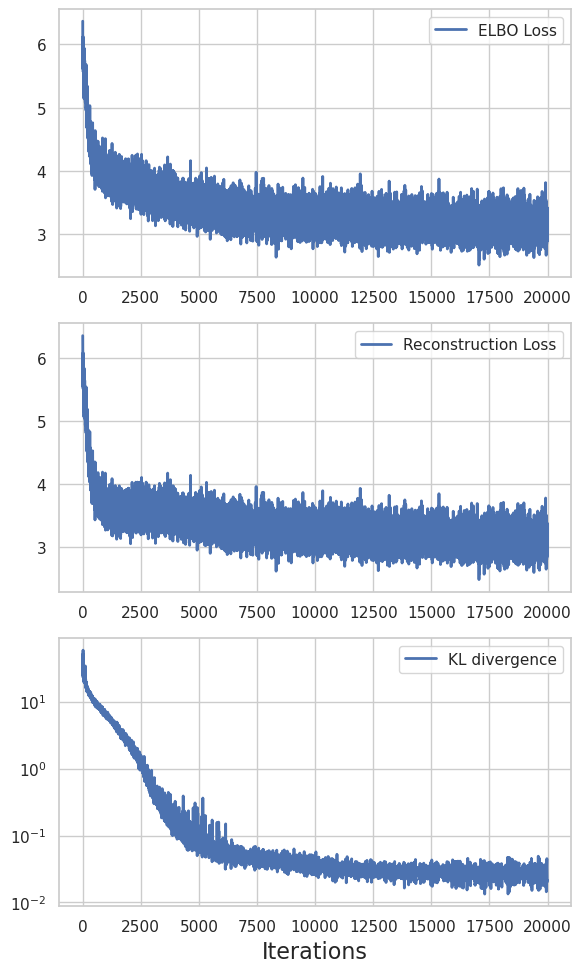

In [14]:
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(3,1,figsize=(6,9.9))

axes[0].plot(losses['LOSS_VAE'][10:], label='ELBO Loss', linewidth=2)
axes[1].plot(losses['LOSS_RECONSTRUCTION'][10:], label='Reconstruction Loss', linewidth=2)
axes[2].plot(losses['LOSS_KLDIVERGENCE'][10:], label='KL divergence', linewidth=2)

#ax.set_ylabel('Loss', fontsize=16)
axes[2].set_xlabel('Iterations', fontsize=16)

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')

axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [16]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [17]:
n_sampling = 30000

smi_after = SMILES_generate(my_generator, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:52<00:00, 50.66it/s]


In [18]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_1_pretraining_ReBADD/gsk3_jnk3_qed_sa/smi_after.csv
